# Fine scales variance of surface relative vorticity

__purpose__ : metric for the intensity of the fine scales in NATL60-CJM165 simulation

__steps__ :

  * Snapshots of relative vorticity (15 March - 15 October 2013 )
  * 2D Lanczos filtering with 2° (~150-200km) cut-off frequency = > done with independent script 2DLanczosHighPassFilter.py that produced netcdf files containing small scales only 
  * Variance of the high-pass filtered relative surface vorticity =>
  * boxcar averaging 1°x1°x1 month 
  * Maps of fine scales variance of relative vorticity in March and October 2013

## 1. Importing external modules

In [1]:
## magics

%load_ext version_information 
%version_information numpy,xarray,netCDF4


Software versions
Python 2.7.11 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 4.2.0
OS Linux 3.16.0 4 amd64 x86_64 with debian 8.5
numpy 1.11.1
xarray 0.9.1
netCDF4 1.2.4
Tue May 23 14:37:05 2017 CEST

In [2]:
## path for mdules

import sys
sys.path.insert(0,"/home/albert/lib/python")

In [3]:
## imports

import numpy as np
import dask
import xarray as xr
import GriddedData
import time

In [4]:
#- Other modules
import os
from glob import glob
import numpy.ma as ma
import scipy as sc
import WavenumberSpectrum as ws
import dask.array as da
from netCDF4 import Dataset

### palette
from matplotlib.colors import LogNorm
import matplotlib.cm as mplcm
import colormap as cmaps
import matplotlib.cm as cm

import seaborn as sns

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic

### quick plot
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

## local/specific imports
import oocgcm
import oocgcm.filtering
import oocgcm.filtering.linearfilters as tf
%matplotlib inline

## 2. Dataset

In [5]:
dir="/media/extra/DATA/NATL60/NATL60-CJM165-S/"
files03="NATL60-CJM165_y2013m03d*.1d_curloverf.nc"
files09="NATL60-CJM165_y2013m09d*.1d_curloverf.nc"

tfiles03=dir+files03
tfiles09=dir+files09

!ls $tfiles03
!ls $tfiles09

/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d01.1d_curloverf.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d02.1d_curloverf.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d03.1d_curloverf.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d04.1d_curloverf.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d05.1d_curloverf.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d06.1d_curloverf.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d07.1d_curloverf.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d08.1d_curloverf.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d09.1d_curloverf.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d10.1d_curloverf.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d11.1d_curloverf.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d12.1d_curloverf.nc
/med

In [6]:
gridfile="/media/extra/DATA/NATL60/NATL60-I/NATL60_grid.nc"
!ls $gridfile
grid=xr.open_dataset(gridfile)
navlat= grid['nav_lat']
navlon= grid['nav_lon']


/media/extra/DATA/NATL60/NATL60-I/NATL60_grid.nc


## 3. Plot surface relative vorticity

In [7]:
def load_and_plot(tfiles,title):
    curls = xr.open_mfdataset(tfiles,concat_dim='time_counter')
    curl15=curls['socurloverf'][15]
    navlat= curls['nav_lat'][0]
    navlon= curls['nav_lon'][0]
    cont=np.isnan(curl15)
    
    plt.figure(figsize=(15,11))
    ax = plt.subplot(111)
    ax.autoscale(tight=True)
    pcolor = ax.pcolormesh(navlon,navlat,
      ma.masked_invalid(curl15),cmap=div_cmap,vmin=-1,vmax=1,alpha=1)
    ax.tick_params(labelsize=25)
    ax.contour(navlon,navlat,cont,alpha=0.5,linewidth=0.000001,antialiased=True)
    cbar = plt.colorbar(pcolor,orientation='horizontal',pad=0.1)
    cbar.ax.tick_params(labelsize=35)
    ax.set_xlabel('Longitude (in degree)',fontsize=20)
    ax.set_ylabel('Latitude (in degree)',fontsize=20)
    cbar.ax.tick_params(labelsize=25)
    plt.title(title,fontsize=25)
    

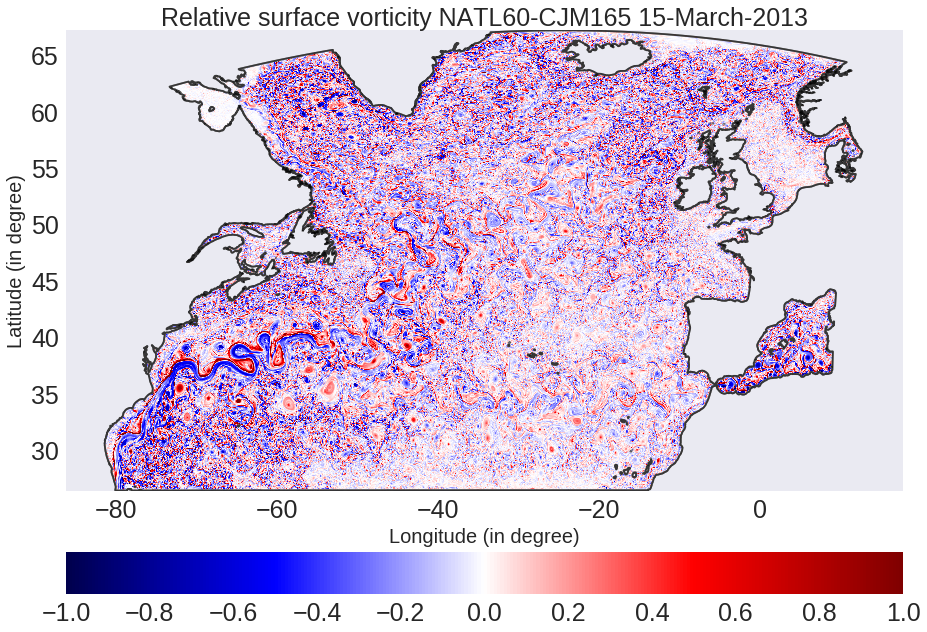

In [8]:
load_and_plot(tfiles03,'Relative surface vorticity NATL60-CJM165 15-March-2013')

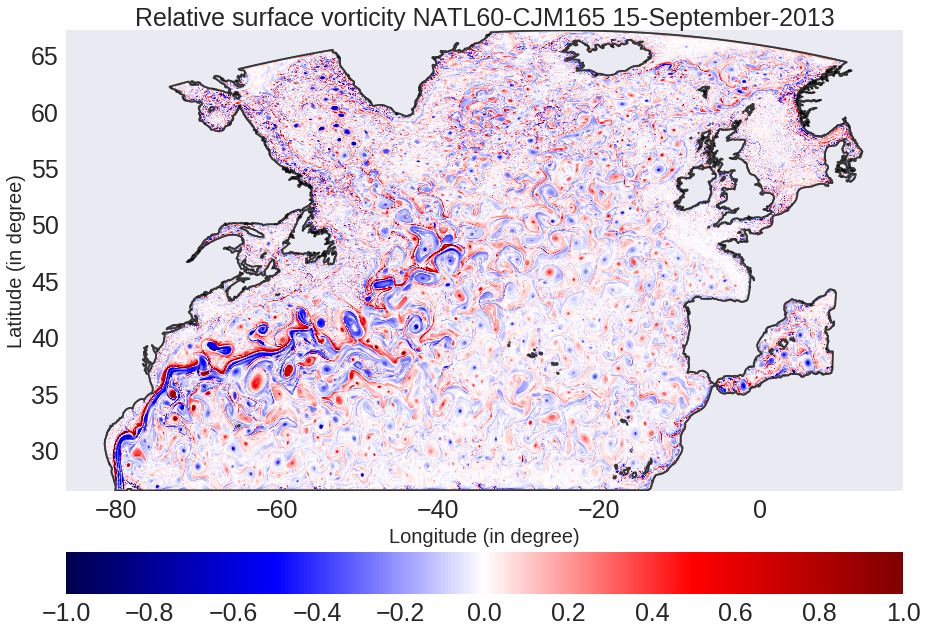

In [8]:
load_and_plot(tfiles09,'Relative surface vorticity NATL60-CJM165 15-September-2013')

## 4. 2D filtering

Calculated elsewhere, stored in files

In [12]:
dir="/media/extra/DATA/NATL60/NATL60-CJM165-S/"
filt_files03="NATL60-CJM165_y2013m03d*.1d_socurloverf_filt2deg_fc80-n80.nc"
filt_files09="NATL60-CJM165_y2013m09d*.1d_socurloverf_filt2deg_n120.nc"

tf_files03=dir+filt_files03
tf_files09=dir+filt_files09

!ls $tf_files03
!ls $tf_files09

/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d01.1d_socurloverf_filt2deg_fc80-n80.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d02.1d_socurloverf_filt2deg_fc80-n80.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d03.1d_socurloverf_filt2deg_fc80-n80.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d04.1d_socurloverf_filt2deg_fc80-n80.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d05.1d_socurloverf_filt2deg_fc80-n80.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d06.1d_socurloverf_filt2deg_fc80-n80.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d07.1d_socurloverf_filt2deg_fc80-n80.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d08.1d_socurloverf_filt2deg_fc80-n80.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d09.1d_socurloverf_filt2deg_fc80-n80.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d10.1d_soc

In [13]:
def small_scales_variance(files,month):
  hpcurl = xr.open_mfdataset(files,concat_dim='time_counter',decode_times=False)['socurloverf']
  hpcurl2 = hpcurl ** 2
  hpcurl2m = hpcurl2.mean(axis=0,keep_attrs=True)
  navlat2=np.array(navlat).squeeze()
  navlon2=np.array(navlon).squeeze()
  mgrd = GriddedData.grid2D(navlat=navlat2, navlon=navlon2)
  crs = GriddedData.grdCoarsener(mgrd,crs_factor=60)
  hpcurl2mc = crs.return_ravel(np.asarray(hpcurl2m))
  hpcurl2mcm = np.mean(hpcurl2mc,axis=-3)
  latcrs=crs.return_ravel(np.asarray(navlat2))
  loncrs=crs.return_ravel(np.asarray(navlon2))
  latcrsm=np.mean(latcrs,axis=-3)
  loncrsm=np.mean(loncrs,axis=-3)

  fig = plt.figure(figsize=(15,11))
  ax = plt.subplot(111)
  ax.autoscale(tight=True)
  cont=np.isnan(hpcurl2m)

  pcolor = ax.pcolormesh(loncrsm,latcrsm,ma.masked_invalid(hpcurl2mcm),cmap=seq_cmap,vmin=0,vmax=0.1,alpha=1)
  ax.tick_params(labelsize=25)
  ax.contour(navlon,navlat,cont,alpha=0.5,linewidth=0.000001,antialiased=True)
  cbar = plt.colorbar(pcolor,orientation='horizontal',pad=0.1)
  cbar.ax.tick_params(labelsize=35)
  ax.set_xlabel('Longitude (in degree)',fontsize=20)
  ax.set_ylabel('Latitude (in degree)',fontsize=20)
  cbar.ax.tick_params(labelsize=25)
  cbar.set_label('Small scales relative vorticity variance in '+month,fontsize=25)
  plt.savefig('fine_scale_variance_socurloverf_NATL60-CJM165_'+month+'.png')
  

/home/albert/anaconda2/lib/python2.7/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


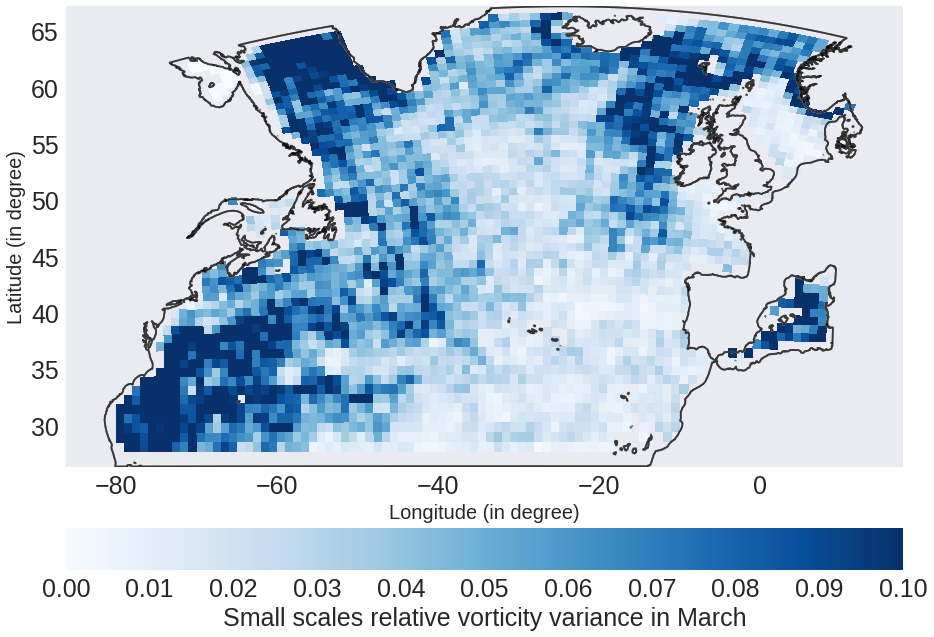

In [14]:
small_scales_variance(tf_files03,'March')

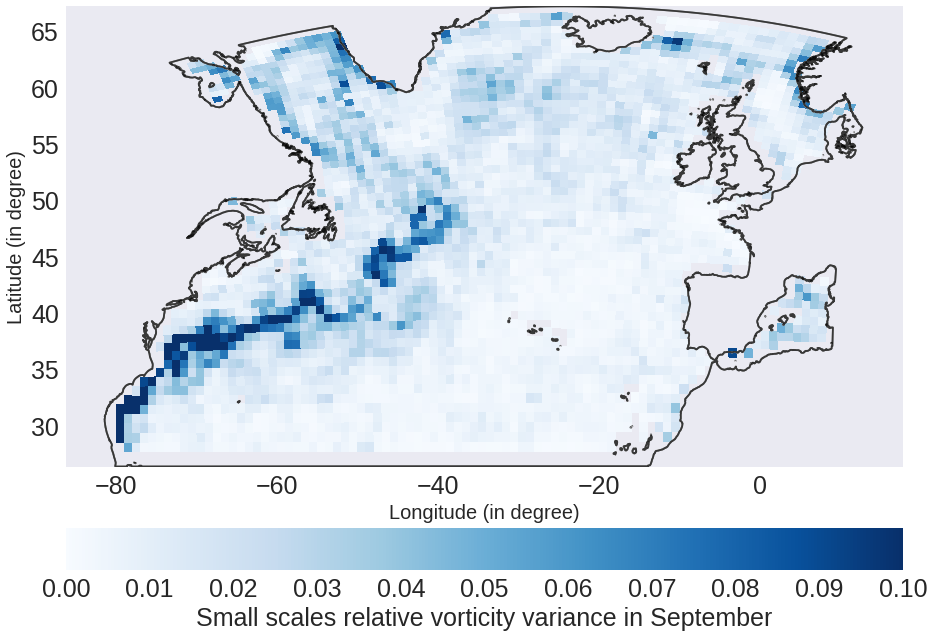

In [15]:
small_scales_variance(tf_files09,'September')

In [16]:
from datetime import date
today = date.today()
today

datetime.date(2017, 5, 24)

In [17]:
today.day

24